# Проект по SQL

## Описание проекта 

Коронавирус застал мир врасплох, изменив привычный порядок вещей. В свободное время жители городов больше не выходят на улицу, не посещают кафе и торговые центры. Зато стало больше времени для книг. Это заметили стартаперы — и бросились создавать приложения для тех, кто любит читать.
Ваша компания решила быть на волне и купила крупный сервис для чтения книг по подписке. Ваша первая задача как аналитика — проанализировать базу данных.
В ней — информация о книгах, издательствах, авторах, а также пользовательские обзоры книг. Эти данные помогут сформулировать ценностное предложение для нового продукта.

### Описание данных

**Таблица `books`**
Содержит данные о книгах:
- book_id — идентификатор книги;
- author_id — идентификатор автора;
- title — название книги;
- num_pages — количество страниц;
- publication_date — дата публикации книги;
- publisher_id — идентификатор издателя.

**Таблица `authors`**
<br>
Содержит данные об авторах:
- author_id — идентификатор автора;
- author — имя автора.

**Таблица `publishers`**
Содержит данные об издательствах:
- publisher_id — идентификатор издательства;
- publisher — название издательства;

**Таблица `ratings`**
<br>
Содержит данные о пользовательских оценках книг:
- rating_id — идентификатор оценки;
- book_id — идентификатор книги;
- username — имя пользователя, оставившего оценку;
- rating — оценка книги.
<br>

**Таблица `reviews`**
<br>
Содержит данные о пользовательских обзорах:
- review_id — идентификатор обзора;
- book_id — идентификатор книги;
- username — имя автора обзора;
- text — текст обзора.

### Схема данных

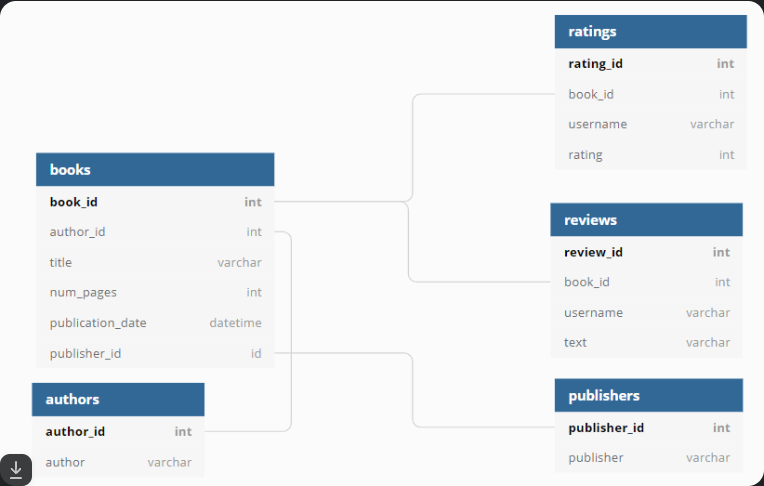

## Задачи проекта
- Посчитайте, сколько книг вышло после 1 января 2000 года;
- Для каждой книги посчитайте количество обзоров и среднюю оценку;
- Определите издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры;
- Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками;
- Посчитайте среднее количество обзоров от пользователей, которые поставили больше 48 оценок.



In [1]:
#!pip install psycopg2-binary
#!pip install sqlalchemy
# импортируем библиотеки
import pandas as pd
from sqlalchemy import text, create_engine

# устанавливаем параметры
db_config = {'user': 'praktikum_student', # имя пользователя
'pwd': 'Sdf4$2;d-d30pp', # пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения
'db': 'data-analyst-final-project-db'} # название базы данных
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)

# сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

# чтобы выполнить SQL-запрос, используем Pandas
query = '''SELECT * FROM books LIMIT 5'''

con=engine.connect()

pd.io.sql.read_sql(sql=text(query), con = con)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


### Количество книг после 1 января 2000

In [2]:
books = '''
SELECT COUNT(book_id) AS books
FROM books 
WHERE publication_date >= '2000-01-02';
'''
pd.io.sql.read_sql(books, con = engine)

,books
0,819


После 1 января 2000 года вышло **819** книг

### Количество обзоров и средняя оценка каждой книги

In [3]:
avg_rate = '''                              
SELECT
    books.title AS book_title,
    books.book_id AS book_id,
    AVG(ratings.rating) AS avg_rate,
    COUNT(DISTINCT reviews.review_id) AS count_reviews 
FROM
    books
JOIN ratings ON ratings.book_id = books.book_id
LEFT JOIN reviews ON reviews.book_id = books.book_id
GROUP BY
    books.title,
    books.book_id
ORDER BY
    count_reviews DESC;
''' 

pd.io.sql.read_sql(avg_rate, con = engine)

,book_title,book_id,avg_rate,count_reviews
0,Twilight (Twilight #1),948,3.662500,7
1,Water for Elephants,963,3.977273,6
2,The Glass Castle,734,4.206897,6
3,Harry Potter and the Prisoner of Azkaban (Harr...,302,4.414634,6
4,The Curious Incident of the Dog in the Night-Time,695,4.081081,6
...,...,...,...,...
995,Anne Rice's The Vampire Lestat: A Graphic Novel,83,3.666667,0
996,The Natural Way to Draw,808,3.000000,0
997,The Cat in the Hat and Other Dr. Seuss Favorites,672,5.000000,0
998,Essential Tales and Poems,221,4.000000,0


Данный запрос отражает количество запросов и среднюю оценку каждой книги

### Издательство, которое выпустило наибольшее число книг толще 50 страниц

In [4]:
publisher = '''
SELECT
     publishers.publisher AS publisher,
     COUNT(books.book_id) AS count_books
FROM
    publishers
JOIN books ON books.publisher_id = publishers.publisher_id
WHERE
    books.num_pages > 50
GROUP BY
    publisher
ORDER BY 
    count_books DESC
    LIMIT 1;

'''
pd.io.sql.read_sql(publisher, con = engine)

,publisher,count_books
0,Penguin Books,42


Издательство, которое выпустило наибольшее число книг толще 50 страниц - **Penguin Books**

### Автор с самой высокой средней оценкой книг (учитываются только книги с 50 и более оценками)

In [5]:
author_avg = '''
SELECT
    authors.author_id AS id,
    authors.author AS author,
    ROUND(AVG(ratings.rating),2) AS avg_rating,
    COUNT(ratings.rating_id) AS count_rating
FROM
    authors
INNER JOIN books ON books.author_id = authors.author_id
INNER JOIN ratings ON ratings.book_id = books.book_id
GROUP BY
    books.book_id,
    author,
    id
HAVING 
    COUNT(ratings.rating_id) > 50
ORDER BY
    avg_rating DESC
    LIMIT 10;
'''
pd.io.sql.read_sql(author_avg, con = engine)

,id,author,avg_rating,count_rating
0,236,J.K. Rowling/Mary GrandPré,4.41,82
1,240,J.R.R. Tolkien,4.39,74
2,236,J.K. Rowling/Mary GrandPré,4.29,80
3,402,Markus Zusak/Cao Xuân Việt Khương,4.26,53
4,236,J.K. Rowling/Mary GrandPré,4.25,73
5,376,Louisa May Alcott,4.19,52
6,236,J.K. Rowling/Mary GrandPré,4.19,75
7,240,J.R.R. Tolkien,4.13,88
8,498,Rick Riordan,4.08,62
9,621,William Golding,3.90,71


Автор с самой высокой средней оценкой книг - **J.K. Rowling/Mary GrandPré**

### Cреднее количество обзоров от пользователей, которые поставили больше 48 оценок

In [6]:
avg_rate = '''
SELECt
    ROUND(AVG(review.review_cnt),2) AS avg_review
FROM
    (SELECT COUNT(review_id) AS review_cnt
     FROM 
         reviews
     WHERE
         username
     IN 
         (SELECT username
          FROM
              ratings
          GROUP BY
              username
          HAVING
              COUNT(ratings) > 48)
          GROUP BY 
              username) 
                        AS
                        review;
'''
pd.io.sql.read_sql(avg_rate, con = engine)

,avg_review
0,24.0


 Cреднее количество обзоров от пользователей, которые поставили больше 48 оценок, составляет **24 обзора**

### Таблица 1

Таблица, которая содержит по году публикации:
- количество издательств,
- выпущенных книг;
- сколько всего тысяч страниц было в изданных книгах.

In [7]:
year = '''
SELECT
    EXTRACT(YEAR FROM publication_date) as year,
    COUNT(book_id) AS count_books,
    COUNT(DISTINCT p.publisher) AS count_publishers,
    round(SUM(num_pages) / 1000, 5) AS pages_thousand
FROM publishers AS p
JOIN books AS b ON b.publisher_id = p.publisher_id
GROUP BY year
ORDER BY year DESC;
'''
pd.io.sql.read_sql(year, con = engine)

,year,count_books,count_publishers,pages_thousand
0,2020.0,1,1,0.0
1,2019.0,2,2,0.0
2,2014.0,2,1,0.0
3,2013.0,1,1,0.0
4,2012.0,3,3,2.0
5,2011.0,1,1,0.0
6,2010.0,7,6,2.0
7,2009.0,6,6,2.0
8,2008.0,4,4,1.0
9,2007.0,50,38,18.0


Пик продажа книг с 2003 по 2006 год. Самый "результативный" год - 2006

### Таблица 2

Таблица, которая содержит среднюю оценку тех книг, на которые написало отзывов более 3 человек и отдельно среднюю оценку остальных книг, сделайте выводы какой рейтинг больше.

In [9]:
avg_rate_books = '''
WITH table1 as (select 
AVG(ratings.rating) as avg_rate
FROM ratings
WHERE book_id in (select reviews.book_id
FROM reviews
GROUP BY reviews.book_id
having COUNT(DISTINCT reviews.review_id) <= 3)),

table2 as (select 
AVG(ratings.rating) as avg_rate
FROM ratings
WHERE book_id in (select reviews.book_id
FROM reviews
GROUP BY reviews.book_id
HAVING COUNT(DISTINCT reviews.review_id) > 3))

SELECT 
AVG(table1.avg_rate) AS no_query,
AVG(table2.avg_rate) AS more_then_3
FROM table1,table2
'''
pd.io.sql.read_sql(avg_rate_books, con = engine)

,no_query,more_then_3
0,3.890191,3.949505


Средняя оценка книг у которых есть отзывы более чем от 3 человек имеют небольшое различие с средней оценкой книг у которых может и не быть обзоров. Можно сделать вывод, что количество отзывов незначительно влияют на среднюю оценку книги. Различие в пару сотых

## Итоговый вывод

- После 1 января 2000 года было выпущено **819 книг**
- Наиболее популярная книга для отзывов - **Twilight (Twilight #1)**
- Издательство, которое выпустило наибольшее число книг толще 50 страниц **Penguin Books**
- Автор с самой высокой средней оценкой книг - **J.K. Rowling/Mary GrandPré**
- Cреднее количество обзоров от пользователей, которые поставили больше 48 оценок, составляет **24 обзора**